This file contains time series analysis for the combined dog adoption data from Austin, TX and austin, CA.

We use a combination of baseline models and other more advanced ones (see below). We also include models from extreme value analysis, inspired by "Modeling Extreme Events in Time Series and Their Impact on Seasonal Adjustment in the Post-Covid-19 Era", Anindya Roy,and Tucker S. McElroy.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

from datetime import datetime

set_style("whitegrid")

In [87]:
# read csv and change date columns into dtype = datetime64
df = pd.read_csv("../main_data/CleanedDataOnePlace.csv", parse_dates=["Date"])

/tmp/ipykernel_30395/1664856861.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../main_data/CleanedDataOnePlace.csv", parse_dates=["Date"])


In [88]:
df.head()

,Date,SonomaIntakeTotals,SonomaOutcomeTotals,SonomaDifferences,SonomaRatio,Sonoma_intake_stray_abandoned,Sonoma_intake_owner_surrender,Sonoma_intake_euthanasia,Sonoma_intake_public_assist,Sonoma_intake_other_i,...,Austin_Owner_Surrender,Austin_Other,Austin_Adopt,Austin_Euth,Austin_RTO,Austin_Unintended,Austin_Other.1,Inflation Rate,Unemployment Rate,Covid
0,2013-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,0.0,6.0,7.0,11.0,0.0,5.0,1.0,7.2,0.0
1,2013-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,0.0,12.0,2.0,9.0,0.0,10.0,1.0,7.2,0.0
2,2013-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,7.0,0.0,6.0,0.0,5.0,1.0,7.2,0.0
3,2013-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,6.0,3.0,9.0,0.0,5.0,1.0,7.2,0.0
4,2013-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,0.0,22.0,2.0,6.0,0.0,8.0,1.0,7.2,0.0


In [89]:
# Choose dates where both data agree
df = df.loc[(df["Date"] >= pd.Timestamp(year = 2014, month = 1, day =1)) & (df["Date"] <= pd.Timestamp(year = 2024, month = 5, day =1))]

# df = df[df["SonomaRatio"].notna() & df["AustinRatio"].notna()]

# This column contains nans and np.inf, since there are no outcomes data on certain days. fill with 0
df = df.fillna(value={"AustinOutcomeTotal":0})

# Recompute ratios for Sonoma and Austin
df["SonomaRatio"] = df["SonomaIntakeTotals"] / df["SonomaOutcomeTotals"]
df["AustinRatio"] = df["AustinIntakeTotal"] / df["AustinOutcomeTotal"]

# There are some divisions by 0, replace by nan and remove such rows
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df[df["SonomaRatio"].notna() & df["AustinRatio"].notna() & df["SonomaRatio"]].reset_index(drop=True)

## Goal:
- TSA for intakes, outcomes, intakes - outcomes, intakes/outcomes
    - Sonoma
    - Austin
    - Combined?
- baseline models
    - naive (use last value)
    - average
    - trend
    - random walk
    - random walk with drift
    - seasonal???
- other models
- EVA models
- compare with features:
    - CPI
    - unemployment
    - stock prices
    - intake subtypes?
    - etc.

Let's begin with some data visualisation of the two regions.

In [90]:
col_list = ["SonomaIntakeTotals", "SonomaOutcomeTotals","SonomaDifferences","SonomaRatio", "AustinIntakeTotal","AustinOutcomeTotal","AustinDifferences","AustinRatio"]

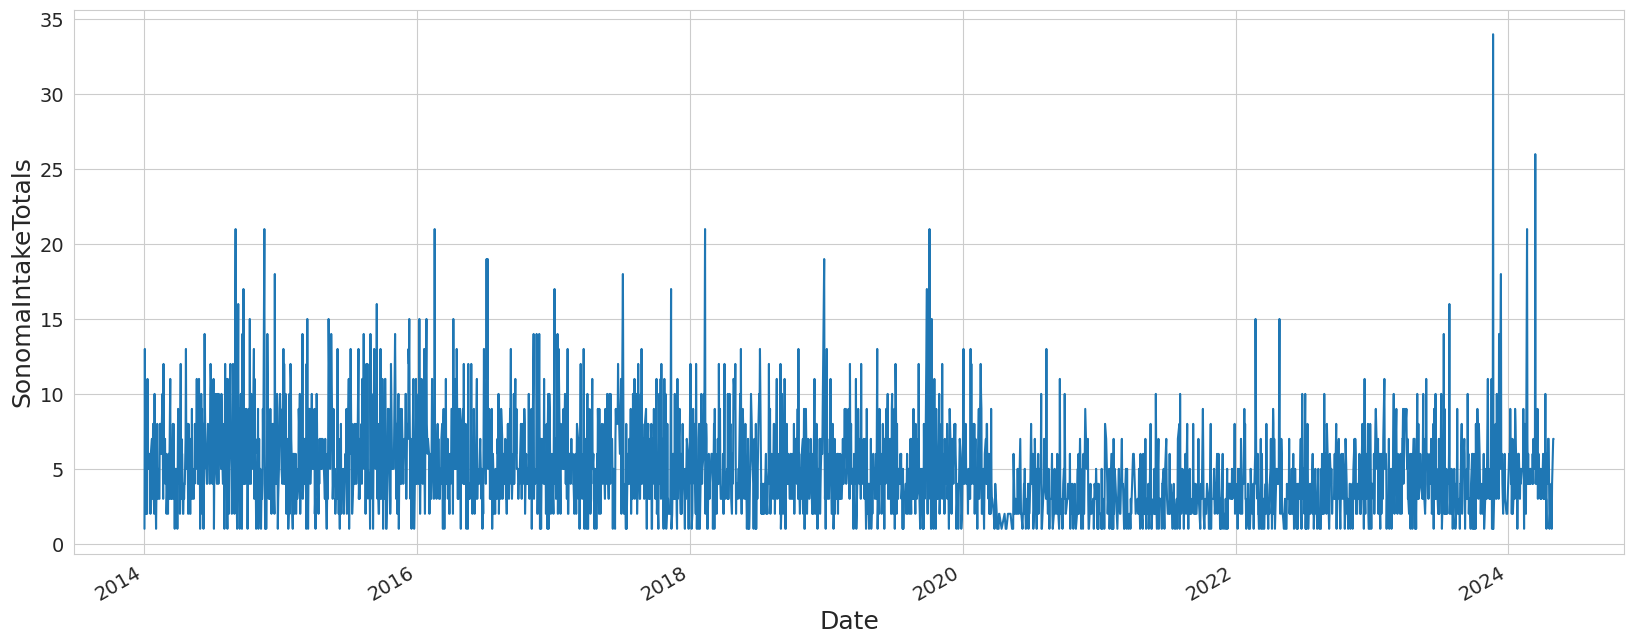

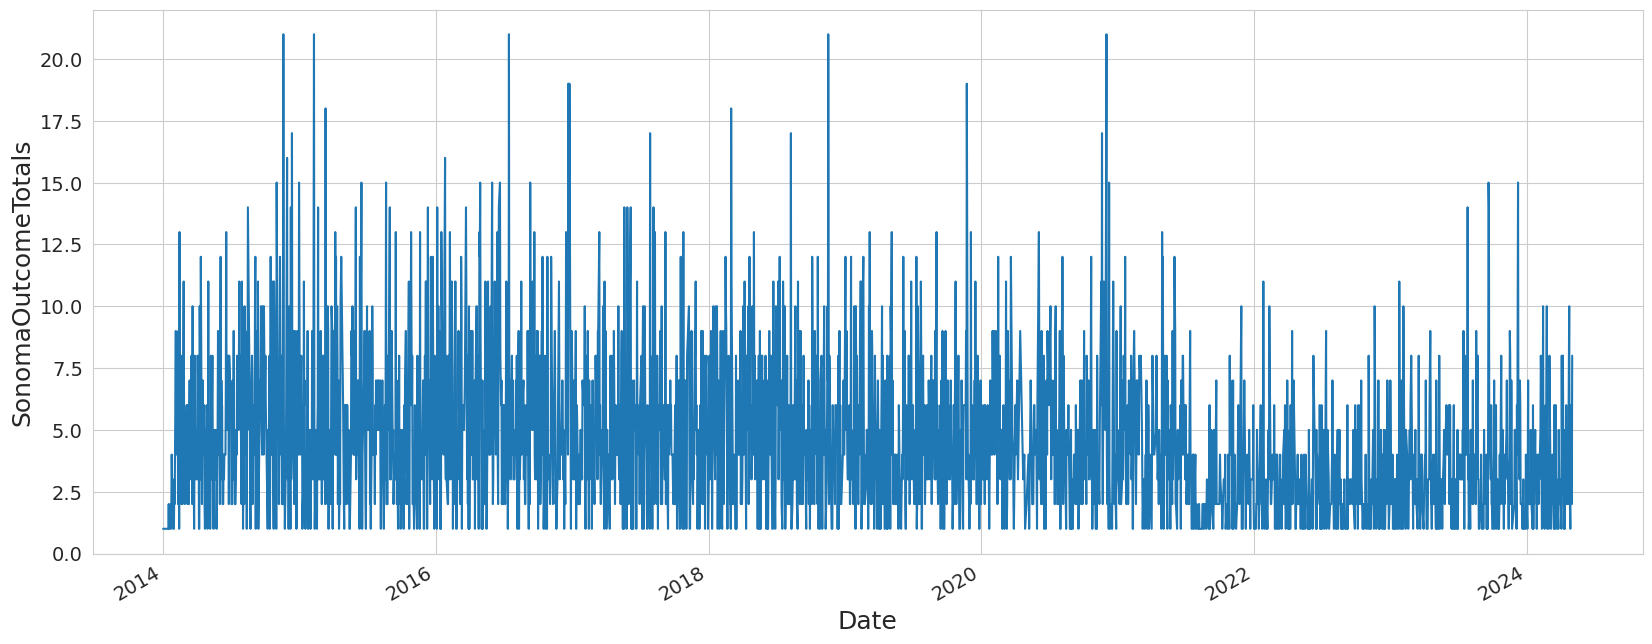

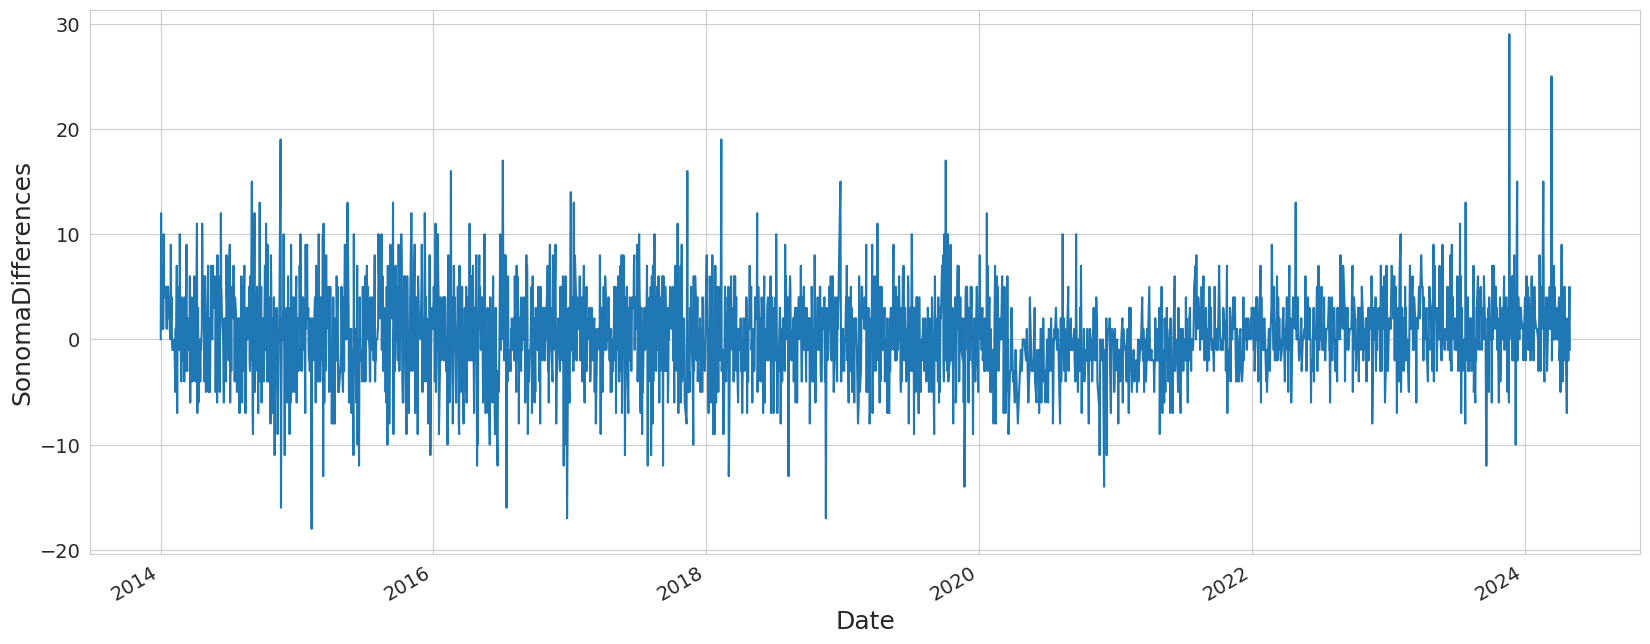

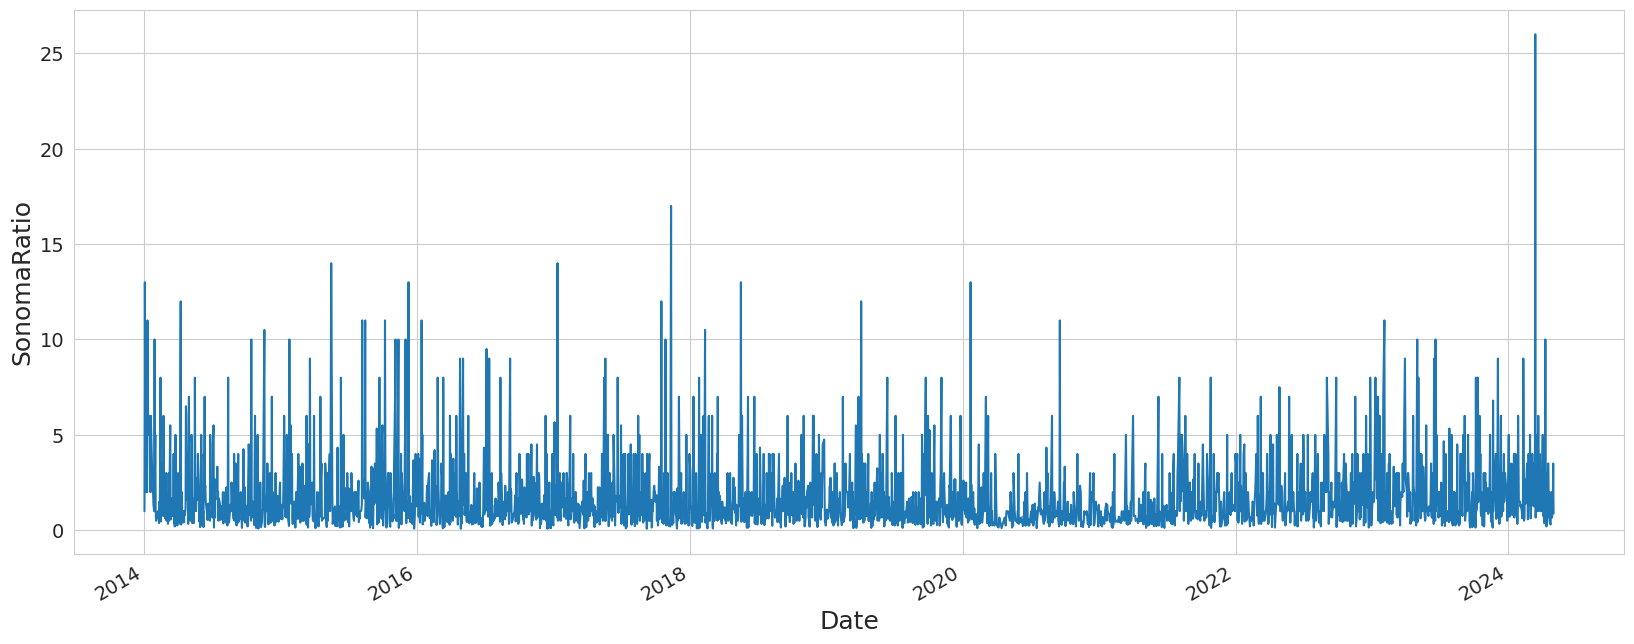

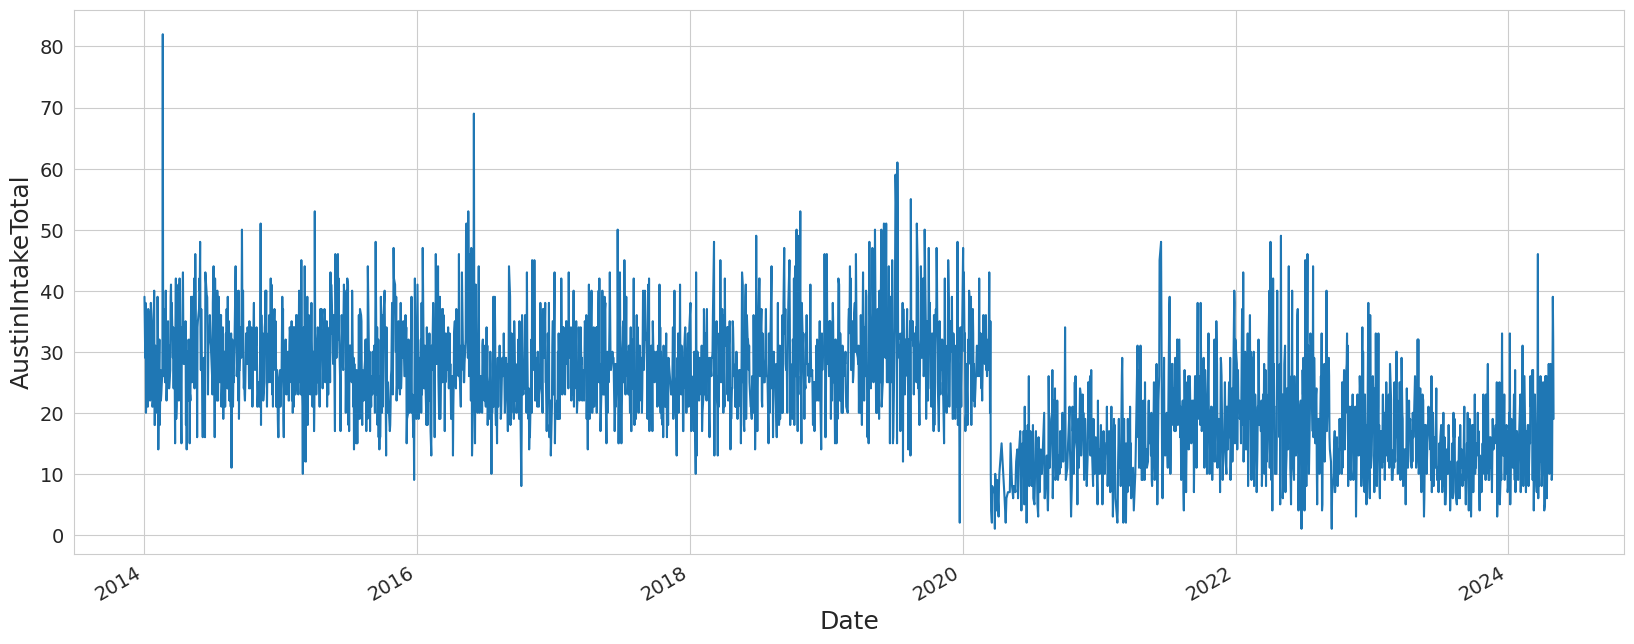

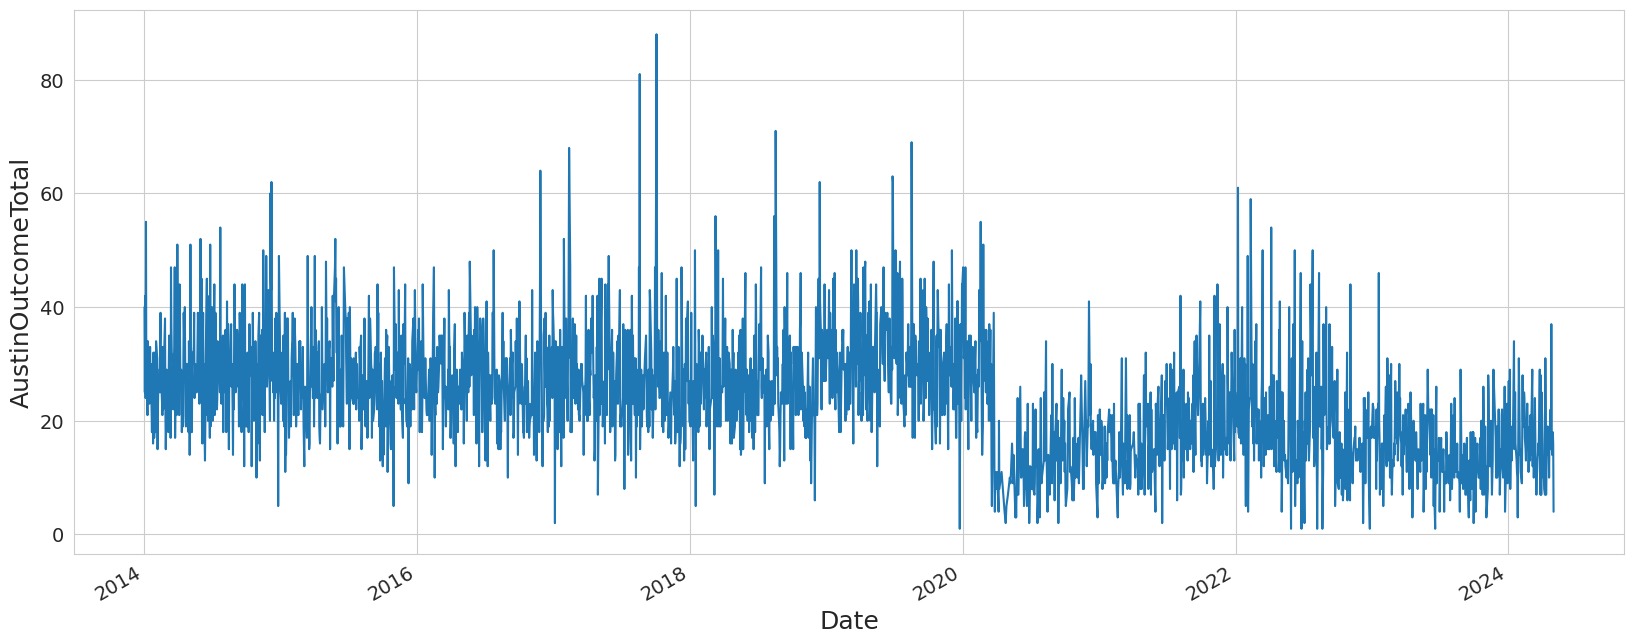

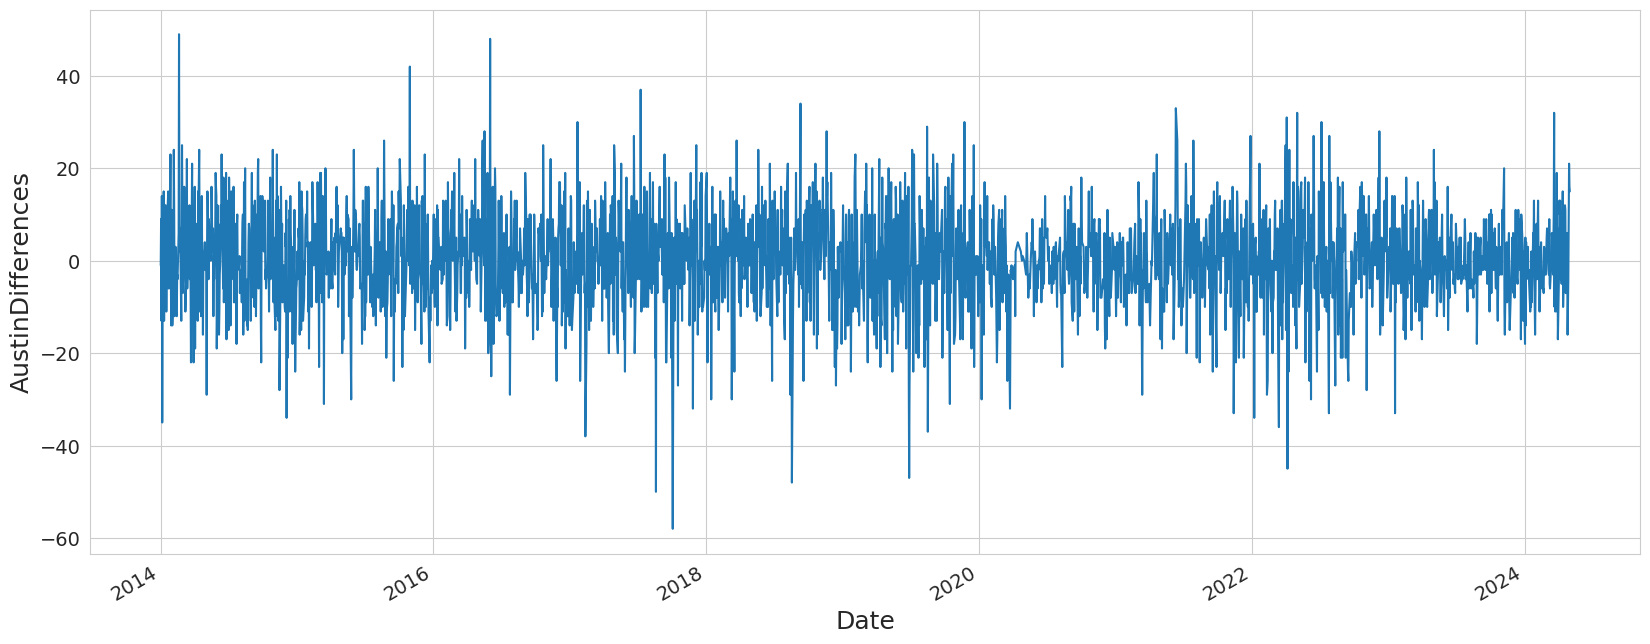

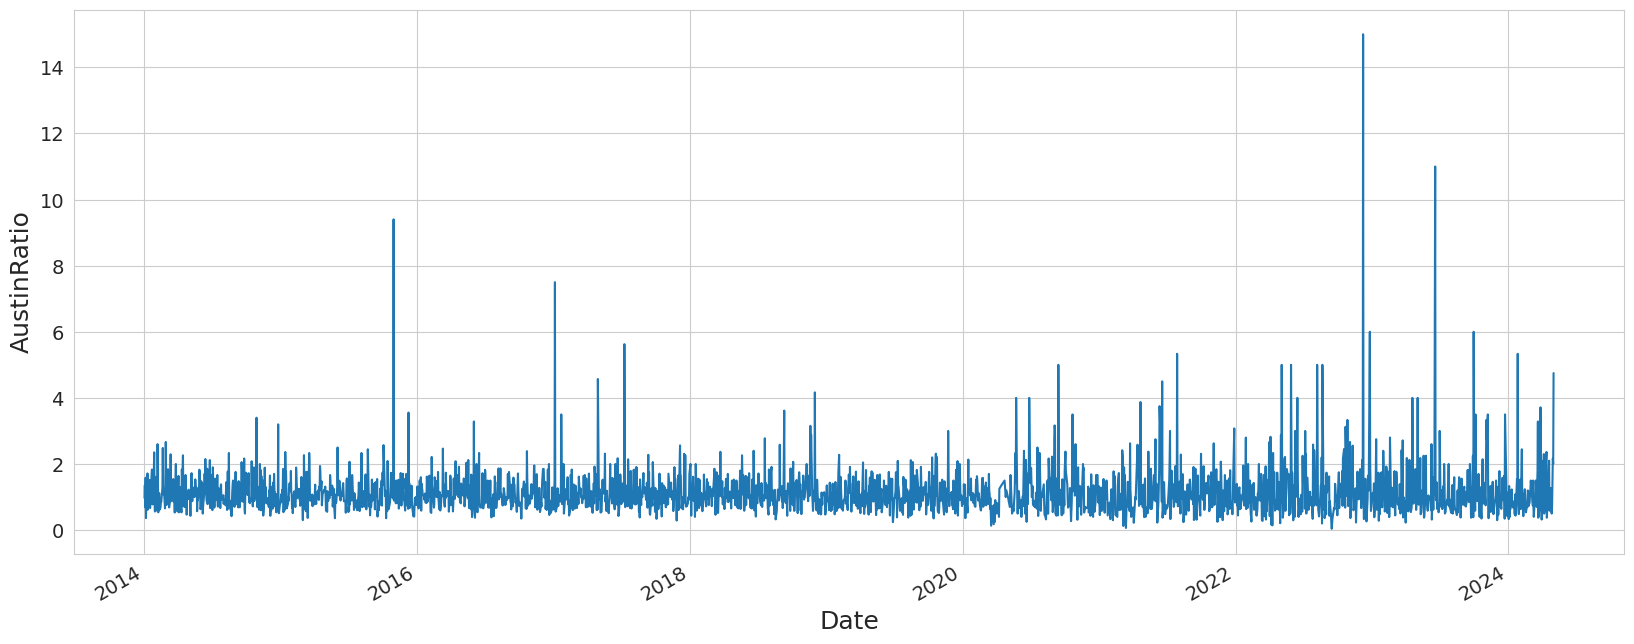

In [115]:
for col in col_list:
    plt.figure(figsize=(20,8))
    plt.plot(df["Date"], df[col])

    plt.xlabel("Date", fontsize=18)
    plt.ylabel(col, fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gcf().autofmt_xdate()

    plt.show()

Sonoma data is "noisier" than Austin's, most likely due to size of data in both regions. One could observe that there is a significant change when COVID-19 (March 16 2020) measures were in place.

In [92]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [93]:
# k = 5
# test size = 14 days
kfold = TimeSeriesSplit(n_splits = 100,
                           test_size = 14)

In [94]:
df_train = df.iloc[:-14].copy()
df_test = df.drop(df_train.index).copy()

### 1. Average forecast
- forecast using average of training set

In [95]:
avg_rmses= np.zeros((6,100))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for j in range(len(col_list)):
        df_tt_avg = df_tt[col_list[j]].mean()
        
        avg_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, df_tt_avg*np.ones(14)))
    i += 1

In [96]:
avg_rmses.mean(axis=1)

array([ 2.89664137,  2.82466534,  3.65008514,  1.63566577, 11.12746148,
       11.17912055,  9.77219194,  0.68489104])

### 2. Naive forecast
- forecast using last value

In [97]:
naive_rmses= np.zeros((6,100))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for j in range(len(col_list)):
        df_tt_naive = df_tt[col_list[j]].values[-1]
        
        naive_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, df_tt_naive*np.ones(14)))
    i += 1

In [98]:
naive_rmses.mean(axis=1)

array([ 3.48097797,  3.39265103,  5.06555599,  2.17975223, 10.0341243 ,
       10.73562274, 13.74536639,  0.94606191])

### 3. (Linear) trend forecast
- use linear regression

In [99]:
from sklearn.linear_model import LinearRegression

In [112]:
slr_rmses= np.zeros((6,100))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    
    for j in range(len(col_list)):
        slr = LinearRegression()
        
        slr.fit(np.array(df_tt.index).reshape(-1,1),
                df_tt[col_list[j]])
        
        pred = slr.predict(np.array(df_ho.index).reshape(-1,1))
        
        slr_rmses[j,i] = np.sqrt(mean_squared_error( df_ho[col_list[j]], pred))
    i += 1

In [113]:
slr_rmses.mean(axis=1)

array([2.67302703, 2.59986129, 3.66572935, 1.6172581 , 9.06072149,
       9.34660525, 9.7716717 , 0.68562657])

### 4. (Linear) trend forecast with drift

### 5. Gaussian noise
- intake/outcome difference (sonoma/austin)

# Note:
- 